In [1]:
%matplotlib inline
from utils import *
from plotting import *
from models import *
import os
import pickle
import matplotlib.cm as cm

## Results

In [2]:
tasks = ['doubleTmaze', 'cylinder', 'permanence', 'thorndike']
model_types = ['sparse-AE', 'AE']

In [3]:
task = tasks[2]
model_type = model_types[0]

In [4]:
# Load dataset and model
dataset, position = load_dataset(directory='datasets/' + task, task=task)
model = Conv_AE(n_hidden=1000).to('cuda')
model.load_state_dict(torch.load('saved_models/main_{}_{}_1000hidden.pth'.format(task, model_type)))

<All keys matched successfully>

In [5]:
# Get latent embeddings
embeddings = get_latent_vectors(dataset, model)
embeddings[embeddings < 1e-5] = 0

In [6]:
features = encode_images(dataset, network='CLIP')  # 'CLIP', 'VGG', or 'Inception'
features.shape

(10000, 512)

In [100]:
images_2d = reduce_dimensionality(features, method='UMAP', umap_args=[30, 0.5])  # 'UMAP', 'TSNE', or 'MDS'
images_2d.shape

(10000, 2)

In [134]:
#np.save('results/main_2d_imageSpace_CLIP-UMAP.npy', images_2d)

In [ ]:
#images_2d = np.load('results/main_2d_imageSpace_CLIP-UMAP.npy')

## Plots

#### Image space with max. act. samples

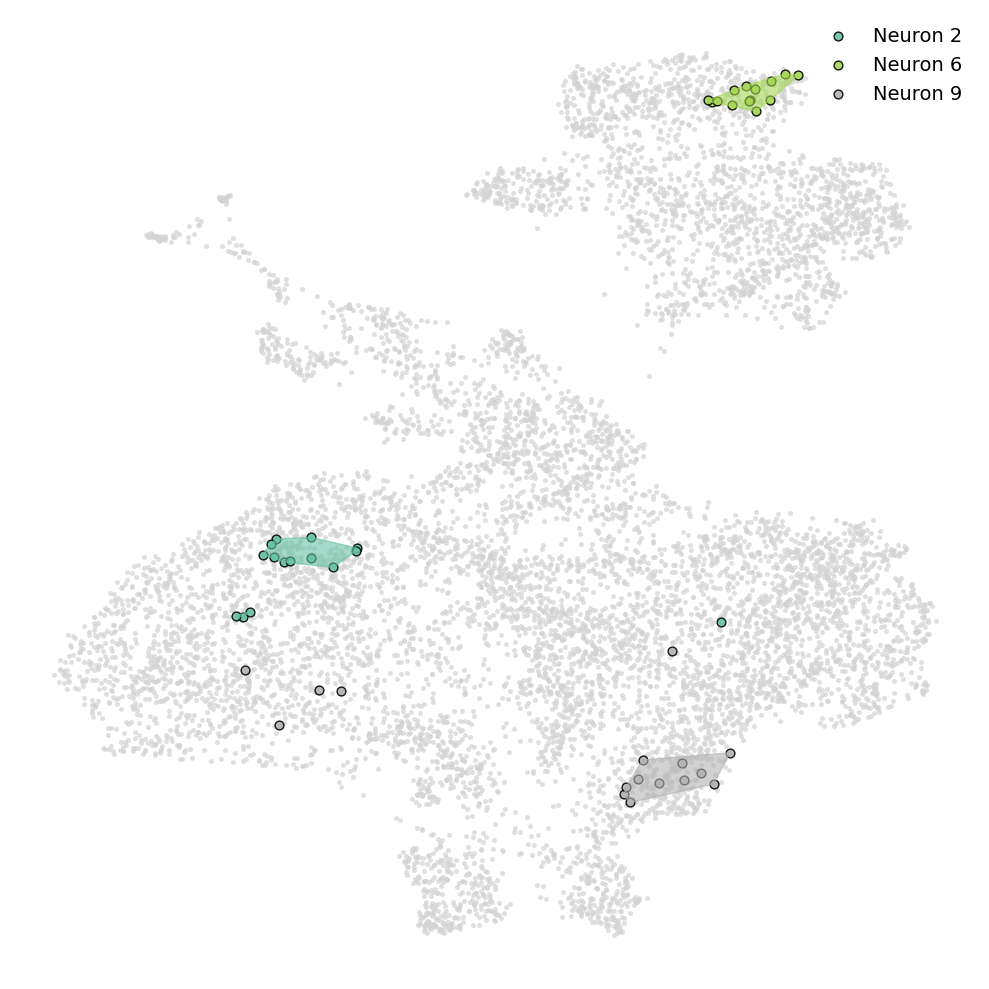

In [162]:
unit_indices = [2, 6, 9]

indxs = get_indxs_imgs_max_activity(embeddings, max_act_thres=0.5)

plt.figure(figsize=(10, 10))
plt.scatter(images_2d[:,0], images_2d[:,1], s=7, color='lightgray', alpha=0.6)

# Use a contemporary colormap for modern aesthetics
colors = cm.Set2(np.linspace(0, 1, len(unit_indices)))

# Dictionary to store the indices of each cluster for each neuron
cluster_indices = {unit_idx: {} for unit_idx in unit_indices}

for unit_idx, color in zip(unit_indices, colors):
    points = images_2d[indxs[unit_idx]]
    plt.scatter(points[:,0], points[:,1], s=40, color=color, label=f'Neuron {unit_idx}', edgecolor='k', alpha=0.9)

    clustering = DBSCAN(eps=1., min_samples=3).fit(points)
    labels = clustering.labels_

    for k in set(labels):
        if k != -1:  # Ignore noise points
            class_member_mask = (labels == k)
            cluster_points = points[class_member_mask]
            cluster_indices[unit_idx][k] = indxs[unit_idx][class_member_mask]

            if len(cluster_points) >= 3:
                hull = ConvexHull(cluster_points)
                polygon = Polygon(cluster_points[hull.vertices])

                # Plot the convex hull
                x, y = polygon.exterior.xy
                plt.fill(x, y, alpha=0.6, color=color)

plt.axis('off')
plt.legend(loc='best', frameon=False, fontsize=14)
plt.tight_layout()

plt.savefig('plots/fig2/A_pointCloud.svg', dpi=600)

plt.show()

In [137]:
print(cluster_indices)

{2: {0: array([ 124,  254, 1219, 1699, 2440, 4176, 4857, 5798, 7707, 7811, 7918],
      dtype=int64), 1: array([4546, 6946, 9452], dtype=int64)}, 6: {0: array([ 933, 1188, 2406, 3064, 4288, 5021, 5427, 6603, 6791, 6991, 7445,
       8061, 8490, 9837], dtype=int64)}, 9: {0: array([ 291,  799, 1290, 3069, 3127, 4335, 4789, 5080, 6371, 7275, 9369],
      dtype=int64)}}


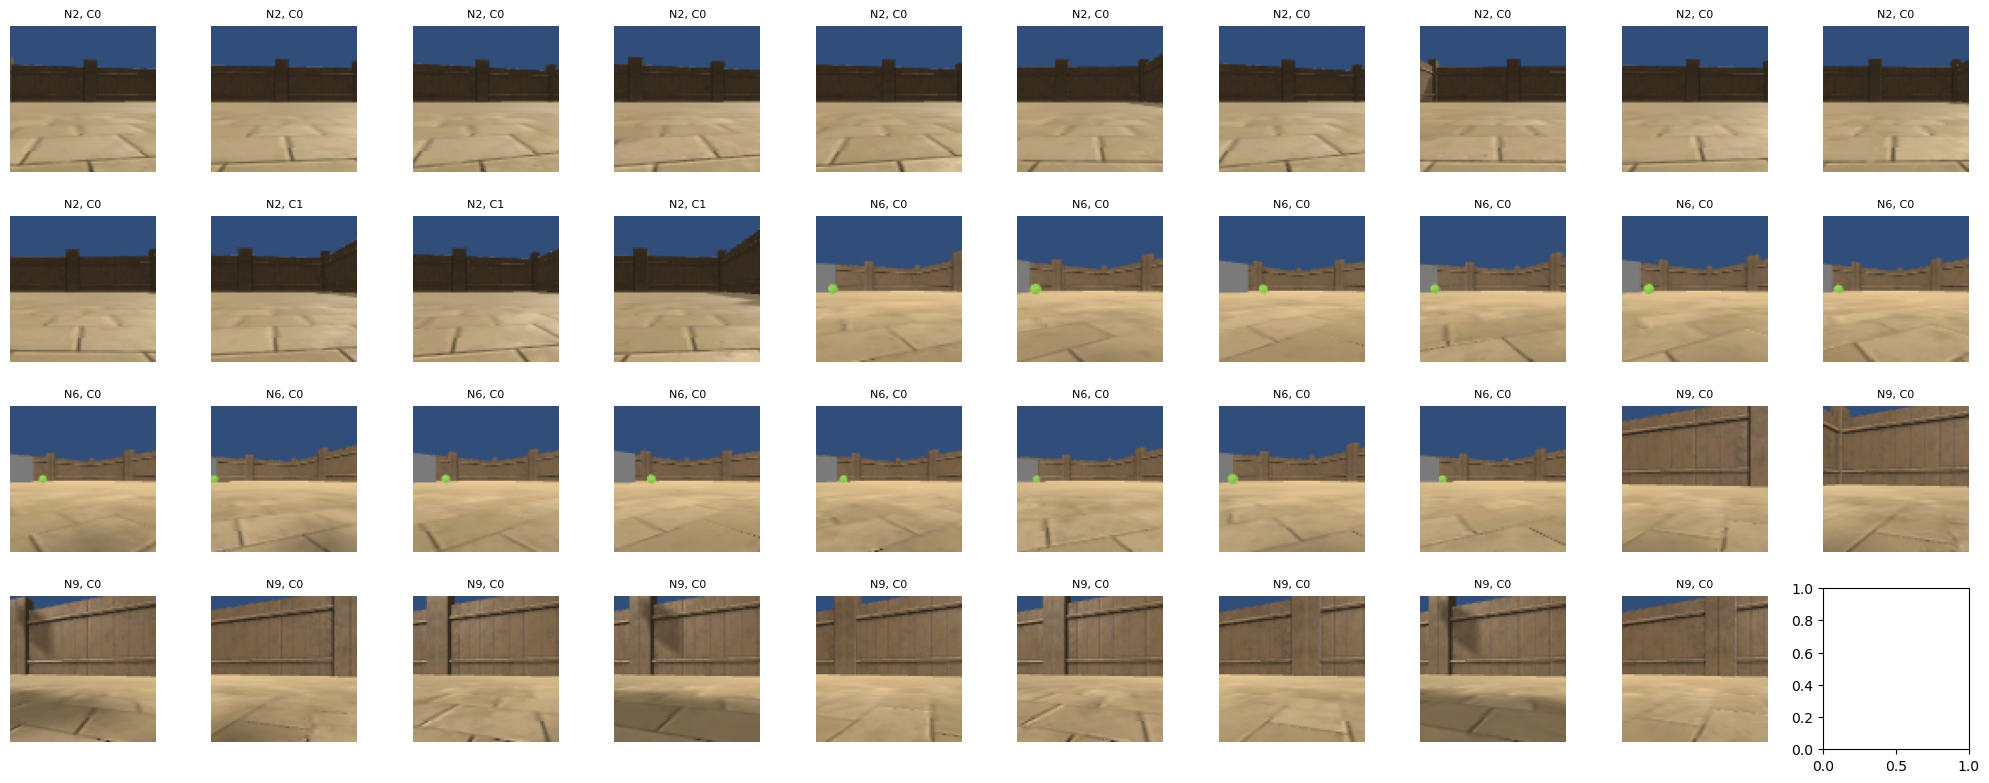

In [146]:
# Flatten the clusters and calculate the total number of images
total_images = sum(len(indices) for clusters in cluster_indices.values() for indices in clusters.values())
num_cols = 10
num_rows = (total_images // num_cols) + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 8), squeeze=False)

img_idx = 0
for unit_idx, clusters in cluster_indices.items():
    for cluster_idx, img_indices in clusters.items():
        for index in img_indices:
            row = img_idx // num_cols
            col = img_idx % num_cols
            ax = axs[row, col]
            ax.imshow(dataset[index], cmap='gray')
            ax.axis('off')
            ax.set_title(f'N{unit_idx}, C{cluster_idx}', fontsize=8)
            img_idx += 1

plt.tight_layout()

plt.savefig('plots/fig2/A_max_act_samples.svg', dpi=600)

plt.show()

#### Hulls tiling

In [150]:
max_act_thres = 0.5
overlap, hull_polygons = build_hulls(embeddings, images_2d, max_act_thres=max_act_thres)
overlap

0.0023379349105648035

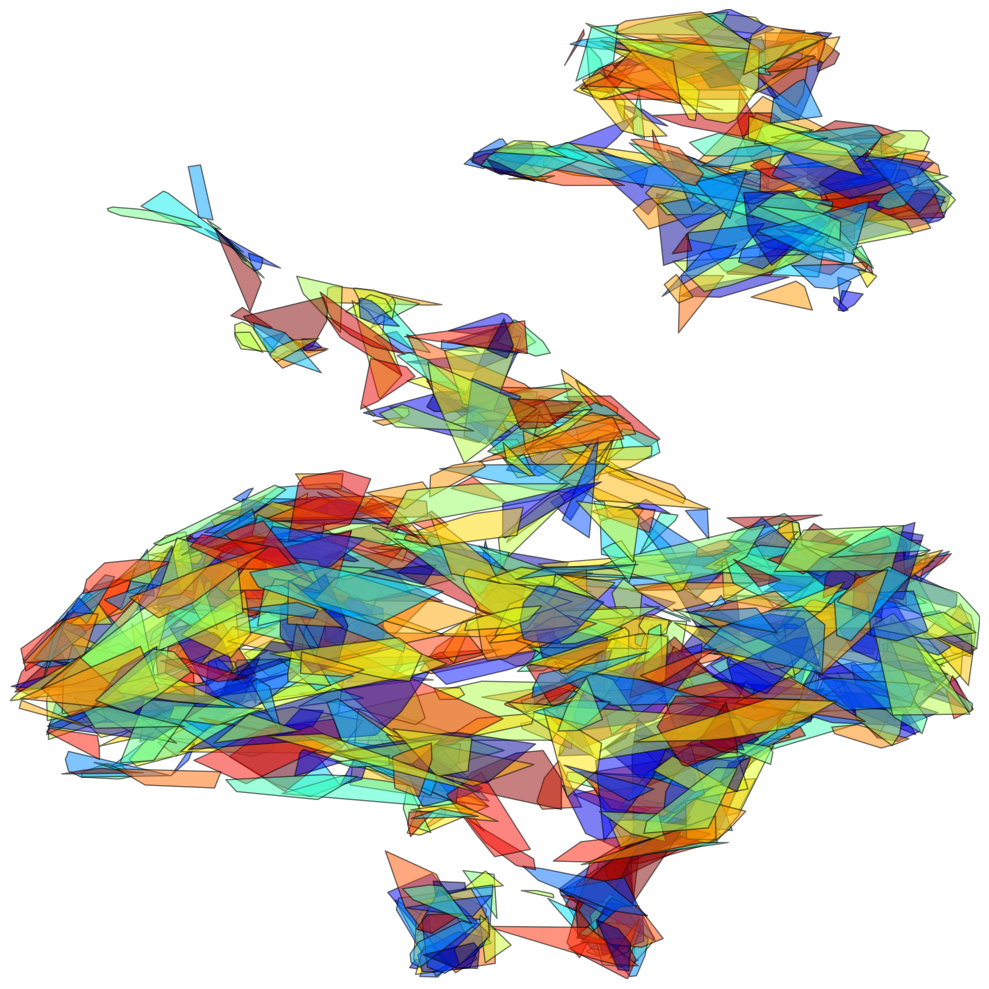

In [163]:
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(10, 10))

# Create a patch collection with the polygons
patches = []
for poly in hull_polygons:
    polygon = MplPolygon(list(poly.exterior.coords), True, edgecolor='black')
    patches.append(polygon)

p = PatchCollection(patches, cmap=plt.cm.jet, alpha=0.5, edgecolor='black')

# Define colors for the polygons
colors = 100 * np.random.rand(len(patches))
p.set_array(np.array(colors))

ax.add_collection(p)

# Set limits and labels
ax.set_xlim(min([point[0] for poly in hull_polygons for point in poly.exterior.coords]),
            max([point[0] for poly in hull_polygons for point in poly.exterior.coords]))
ax.set_ylim(min([point[1] for poly in hull_polygons for point in poly.exterior.coords]),
            max([point[1] for poly in hull_polygons for point in poly.exterior.coords]))
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
#plt.title(f'Overlap: {overlap:.3f}', fontsize=18)

#plt.colorbar(p, ax=ax)

plt.axis('off')

plt.tight_layout()

plt.savefig('plots/fig2/B_hulls_tiling.svg', dpi=600)

plt.show()

#### Unit clamping decoding

In [171]:
features = extract_feature_images(model, clean_embeddings(embeddings), clamping_value='max_unit')

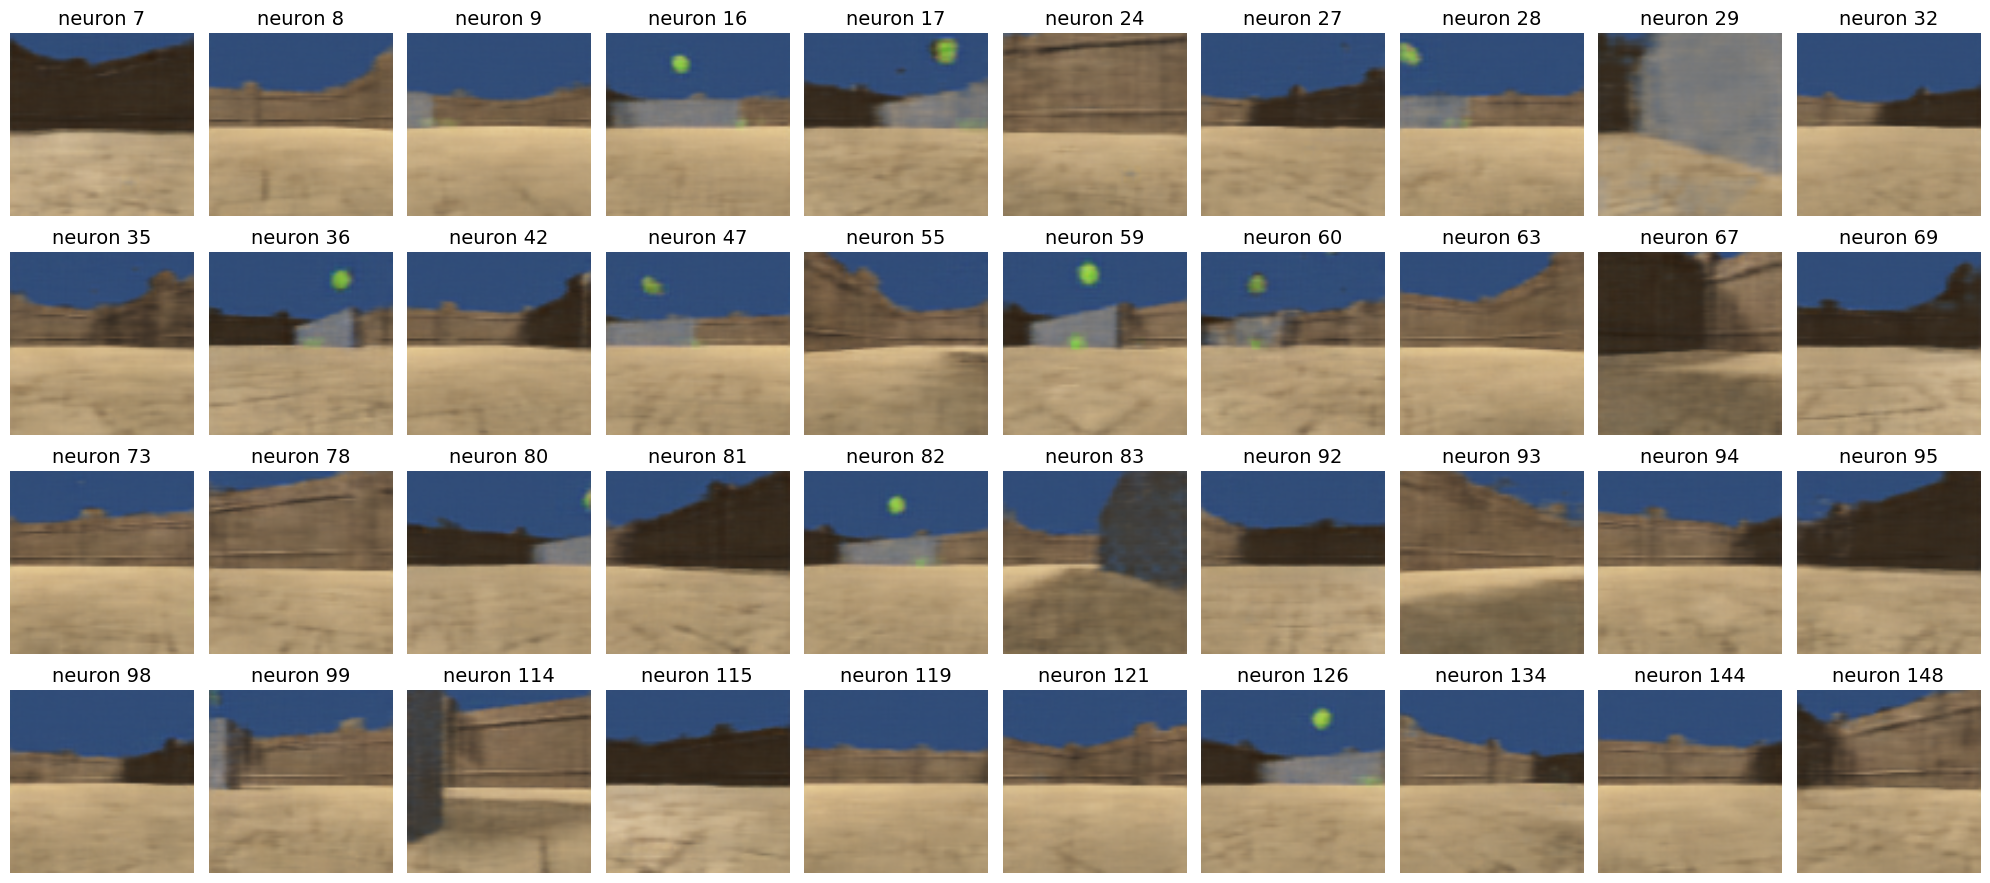

In [181]:
indxs = [7,8,9,16,17,24,27,28,29,32,35,36,42,47,55,59,60,63,67,69,
         73,78,80,81,82,83,92,93,94,95,98,99,114,115,119,121,126,134,144,148]

plt.figure(figsize=(20,9))

for i, indx in enumerate(indxs):
    plt.subplot(4, 10, i+1)
    plt.title('neuron '+str(indx), fontsize=14)
    plt.imshow(features[indx], interpolation='bilinear')
    plt.axis('off')
    
plt.tight_layout()

plt.savefig('plots/fig2/C_unitClamping_imgs.svg', dpi=600)

plt.show()

#### Overlap across threshold values

In [187]:
all_overlaps = {}
for model_type in model_types:
    all_overlaps[model_type] = {}
    for task in tasks:
        print(model_type, task)
        
        # Load dataset and model
        dataset, position = load_dataset(directory='datasets/' + task, task=task)
        model = Conv_AE(n_hidden=1000).to('cuda')
        model.load_state_dict(torch.load('saved_models/main_{}_{}_1000hidden.pth'.format(task, model_type)))

        # Get latent embeddings
        embeddings = get_latent_vectors(dataset, model)
        embeddings[embeddings < 1e-5] = 0
        
        # Compute overlap curves
        max_act_thres_range = np.linspace(0.5, 0.9, 5)
        overlaps = []
        for thres in max_act_thres_range:
            overlap, _ = build_hulls(embeddings, images_2d, max_act_thres=thres)
            overlaps.append(overlap)

        all_overlaps[model_type][task] = overlaps

sparse-AE doubleTmaze
sparse-AE cylinder
sparse-AE permanence
sparse-AE thorndike
AE doubleTmaze
AE cylinder
AE permanence
AE thorndike


In [200]:
# Ensure the directory exists
os.makedirs('results', exist_ok=True)

# Save the results dictionary to a file in the 'results' folder
file_path = os.path.join('results', 'all_overlaps.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(all_overlaps, f)

In [ ]:
# Load and print the results to check
file_path = os.path.join('results', 'all_overlaps.pkl')
with open(file_path, 'rb') as f:
    all_overlaps = pickle.load(f)

In [188]:
# Calculate means and standard deviations
mean_overlaps = {}
std_overlaps = {}
for model_type in model_types:
    task_overlaps = np.array([all_overlaps[model_type][task] for task in tasks])
    mean_overlaps[model_type] = np.mean(task_overlaps, axis=0)
    std_overlaps[model_type] = np.std(task_overlaps, axis=0)

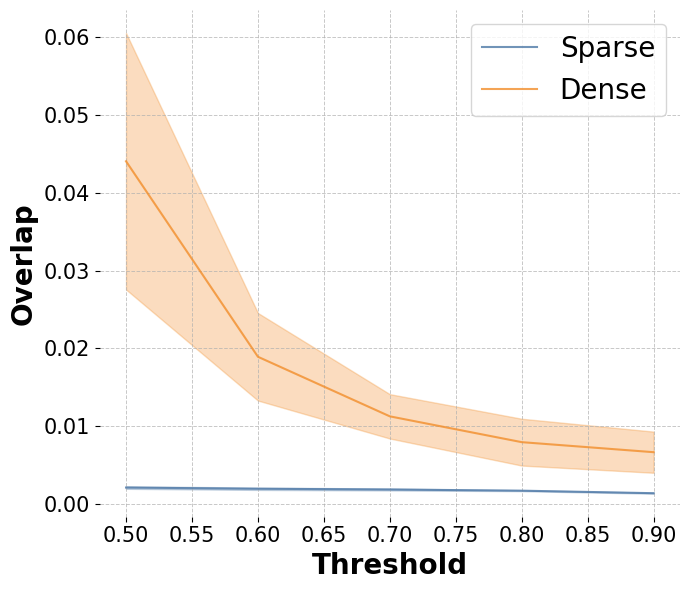

In [199]:
# Plotting
fig, ax = plt.subplots(figsize=(7, 6))

# Custom style settings
colors = {'sparse-AE': '#4E79A7', 'AE': '#F28E2B'}
alpha_value = 0.8

model_types_labels = ['sparse', 'dense']
for i, model_type in enumerate(model_types):
    ax.plot(max_act_thres_range, mean_overlaps[model_type], label=model_types_labels[i].capitalize(), color=colors[model_type], alpha=alpha_value)
    ax.fill_between(max_act_thres_range, mean_overlaps[model_type] - std_overlaps[model_type], mean_overlaps[model_type] + std_overlaps[model_type], color=colors[model_type], alpha=0.3)

ax.set_xlabel('Threshold', fontsize=20, fontweight='bold')
ax.set_ylabel('Overlap', fontsize=20, fontweight='bold')
ax.legend(fontsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Despine for a cleaner look
sb.despine(ax=ax, left=True, bottom=True)

plt.tight_layout()

plt.savefig('plots/fig2/D_overlapCurves.svg', dpi=600)

plt.show()